In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, time

In [123]:
allCSV = [ i for i in os.listdir("euler3/codes-R/") if i.endswith("pdf.csv") ]
allDF  = [ pd.read_csv("euler3/codes-R/" + i) for i in allCSV ]
sorted(allCSV)

['dijkstra_andromeda_500K_1M_2M_10M-10M-c1-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-10M-c2-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-10M-c3-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-10M-c4-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-10M-inferC-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-10M-iteratedC-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-10M-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-1M-c1-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-1M-c2-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-1M-c3-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-1M-c4-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-1M-inferC-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-1M-iteratedC-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-1M-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-2M-c1-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-2M-c2-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-2M-c3-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-2M-c4-pdf.csv',
 'dijkstra_andromeda_500K_1M_2M_10M-2M-in

In [124]:
# Tidy data up
#allCSV.append("sqldbHD_andromeda_100_150_300_1500-150-pdf.csv")

algorithm  = [ i.split("_")[0] for i in allCSV ]
machine    = [ i.split("_")[1] for i in allCSV ]
psize      = [ i.split("-")[1] for i in allCSV ]
infMethod  = [ i.split("-")[-2] for i in allCSV ]

# We messed up on the naming system, so we fix it here
infMethod = [ "standard" if s[0].isnumeric() else s for s in infMethod ]

for idx, df in enumerate(allDF):
    df["algorithm"] = algorithm[idx]
    df["machine"]   = machine[idx]
    df["psize"]     = psize[idx]

    df["infMethod"] = infMethod[idx]

In [125]:
df = pd.concat(allDF)
df["experiment"] = df["title"] + "-" + df["infMethod"]

In [126]:
df = df.drop(columns="Unnamed: 0")
df.columns

Index(['title', 'model', 'estimates', 'crossValid', '-2l', 'AIC', 'CAIC',
       'BIC', 'HQIC', 'elapsed.time', 'optErrorRatio', 'totalInfTime',
       'infTime.mean', 'infTime.sd', 'infTime.n', 'algorithm', 'machine',
       'psize', 'infMethod', 'experiment'],
      dtype='object')

## Apply speedup

In [127]:
df.loc[df["model"] == "Kw-CWG","elapsed.time"] = df.loc[df["model"] == "Kw-CWG","elapsed.time"] * 3.332537
df.loc[df["model"] == "Kw-CWG","totalInfTime"] = df.loc[df["model"] == "Kw-CWG","totalInfTime"] * 3.332537
#df.loc[df["model"] == "Kw-CWG","timePerInf"] = df.loc[df["model"] == "Kw-CWG","timePerInf"] * 3.332537
df.loc[df["model"] == "Kw-CWG","infTime.mean"] = df.loc[df["model"] == "Kw-CWG","infTime.mean"] * 3.332537

# Some sanity checks here

In [128]:
assert( all(df.groupby(by="infMethod").count() == 333) )
assert( all(df.groupby(by="infMethod").count() == 259) )

In [129]:
df.columns

Index(['title', 'model', 'estimates', 'crossValid', '-2l', 'AIC', 'CAIC',
       'BIC', 'HQIC', 'elapsed.time', 'optErrorRatio', 'totalInfTime',
       'infTime.mean', 'infTime.sd', 'infTime.n', 'algorithm', 'machine',
       'psize', 'infMethod', 'experiment'],
      dtype='object')

## A little explanation is due here

- elapsed.time: Total time to perform all inferences
- infTime.mean: mean of the inference procedures that achieved the best values
- totalInfTime: I think it is the time elapsed for inferring the parameters we chose as best.

In [130]:
temp = df[df["model"] == "OLL-GG"]
temp[["elapsed.time", "infTime.mean", "infTime.sd", "totalInfTime"]]

,elapsed.time,infTime.mean,infTime.sd,totalInfTime
5,42.055,1.041500,0.379368,1.206
5,39.751,0.964611,0.345413,1.217
5,54.000,1.361778,0.513871,2.157
5,31.641,0.769250,0.265807,1.000
5,47.188,1.148111,0.337078,1.334
...,...,...,...,...
5,71.712,1.774972,0.454061,2.050
5,64.452,1.535583,0.777650,0.985
5,48.738,1.189222,0.356257,0.643
5,73.455,1.905083,0.502113,1.664


In [131]:
l = { "model": [], "rank": [], "method": [], "metric": []}

for experiment in df["experiment"].unique():
    for metric in ["crossValid", "AIC", "BIC", "HQIC", "CAIC"]:
        temp = df[df["experiment"] == experiment]
        models = np.array(temp["model"])
        value  = np.array(temp[metric])
        method = temp["infMethod"]

        idx = np.argsort(value)

        value = value[idx]
        models = models[idx]
        method = method[idx]
        rank = np.arange(len(models)) + 1
        m    = [ metric for i in rank ]
        
        l["model"].extend(models)
        l["rank"].extend(rank)
        l["method"].extend(method)
        l["metric"].extend(m)
    
allRankings = pd.DataFrame(l)
allRankings

,model,rank,method,metric
0,OLL-GG,1,c3,crossValid
1,E.Weibull,2,c3,crossValid
2,G.Gamma,3,c3,crossValid
3,T.Normal,4,c3,crossValid
4,Kw-CWG,5,c3,crossValid
...,...,...,...,...
11650,G.Gamma,5,c4,CAIC
11651,E.Weibull,6,c4,CAIC
11652,Weibull,7,c4,CAIC
11653,Gamma,8,c4,CAIC


In [132]:
l = []
cm = sns.light_palette("#55BB55", as_cmap=True)

myModels = ["Gamma", "Weibull", "Normal", "T.Normal", "Lognormal", "E.Weibull", "G.Gamma", "Kw-CWG", "OLL-GG"]

for method in allRankings["method"].unique():
    print(method)
    
    wins = pd.DataFrame(data=0, index=myModels, columns=allRankings["metric"].unique())
    wins.index.name = method
    
    for model in allRankings["model"].unique():    
        for metric in allRankings["metric"].unique():
            temp = allRankings[allRankings["method"] == method]
            temp = temp[temp["metric"] == metric]
            temp = temp[temp["rank"] == 1]
            
            count = np.sum(temp["model"] == model)
            wins[metric][model] = count
    
    s = wins.style.background_gradient(cmap=cm)
    l.append([s, method])
l

c3
c2
iteratedC
inferC
c1
c4
standard


[[<pandas.io.formats.style.Styler at 0x7f1b071abd68>, 'c3'],
 [<pandas.io.formats.style.Styler at 0x7f1b03f3ccf8>, 'c2'],
 [<pandas.io.formats.style.Styler at 0x7f1b071ab5c0>, 'iteratedC'],
 [<pandas.io.formats.style.Styler at 0x7f1b071ab898>, 'inferC'],
 [<pandas.io.formats.style.Styler at 0x7f1b071abf28>, 'c1'],
 [<pandas.io.formats.style.Styler at 0x7f1b071abd30>, 'c4'],
 [<pandas.io.formats.style.Styler at 0x7f1b071ba1d0>, 'standard']]

In [98]:
i = 0
print(l[i][1])
l[i][0]

c3


,crossValid,AIC,BIC,HQIC,CAIC
c3,,,,,
Gamma,0,0,0,2,0
Weibull,0,0,0,0,0
Normal,1,0,0,0,0
T.Normal,6,7,8,10,7
Lognormal,0,0,0,1,0
E.Weibull,5,4,5,3,4
G.Gamma,0,0,0,0,0
Kw-CWG,12,14,12,8,14
OLL-GG,13,12,12,13,12


In [99]:
i = 1
print(l[i][1])
l[i][0]

c2


,crossValid,AIC,BIC,HQIC,CAIC
c2,,,,,
Gamma,0,0,0,0,0
Weibull,0,0,0,0,0
Normal,0,0,0,0,0
T.Normal,2,3,4,5,3
Lognormal,6,6,6,6,6
E.Weibull,1,2,2,3,2
G.Gamma,0,0,0,0,0
Kw-CWG,11,9,8,6,8
OLL-GG,17,17,17,17,18


In [100]:
i = 2
print(l[i][1])
l[i][0]

iteratedC


,crossValid,AIC,BIC,HQIC,CAIC
iteratedC,,,,,
Gamma,1,1,3,3,1
Weibull,1,1,1,1,1
Normal,4,0,0,0,0
T.Normal,0,1,1,1,1
Lognormal,6,7,8,9,7
E.Weibull,8,1,1,0,1
G.Gamma,5,0,1,1,0
Kw-CWG,1,13,9,8,13
OLL-GG,11,13,13,14,13


In [101]:
i = 3
print(l[i][1])
l[i][0]

inferC


,crossValid,AIC,BIC,HQIC,CAIC
inferC,,,,,
Gamma,1,1,1,1,1
Weibull,0,0,1,1,0
Normal,0,0,0,0,0
T.Normal,0,0,0,0,0
Lognormal,5,11,12,13,11
E.Weibull,5,3,3,2,3
G.Gamma,2,2,1,1,2
Kw-CWG,7,4,4,4,4
OLL-GG,17,16,15,15,16


In [102]:
i = 4
print(l[i][1])
l[i][0]

c1


,crossValid,AIC,BIC,HQIC,CAIC
c1,,,,,
Gamma,0,0,0,0,0
Weibull,0,0,0,0,0
Normal,0,0,0,0,0
T.Normal,3,3,4,6,3
Lognormal,6,6,6,6,6
E.Weibull,3,2,2,2,2
G.Gamma,0,0,0,0,0
Kw-CWG,8,8,7,6,8
OLL-GG,17,18,18,17,18


In [103]:
i = 5
print(l[i][1])
l[i][0]

c4


,crossValid,AIC,BIC,HQIC,CAIC
c4,,,,,
Gamma,0,0,0,1,0
Weibull,0,0,0,0,0
Normal,3,0,0,0,0
T.Normal,5,7,8,10,7
Lognormal,0,1,1,1,1
E.Weibull,4,3,4,4,3
G.Gamma,1,0,0,0,0
Kw-CWG,11,15,13,9,15
OLL-GG,13,11,11,12,11


In [104]:
i = 6
print(l[i][1])
l[i][0]

standard


,crossValid,AIC,BIC,HQIC,CAIC
standard,,,,,
Gamma,0,0,0,0,0
Weibull,1,0,0,0,0
Normal,0,0,1,1,0
T.Normal,1,1,1,1,1
Lognormal,1,1,1,2,1
E.Weibull,16,14,14,13,14
G.Gamma,0,2,1,1,2
Kw-CWG,0,1,1,1,1
OLL-GG,18,18,18,18,18


In [105]:
l = []
cm = sns.light_palette("#CC4444", as_cmap=True)

myModels = ["Gamma", "Weibull", "Normal", "T.Normal", "Lognormal", "E.Weibull", "G.Gamma", "Kw-CWG", "OLL-GG"]

for method in allRankings["method"].unique():
    wins = pd.DataFrame(data=0, index=myModels, columns=allRankings["metric"].unique())
    wins.index.name = method
    
    for model in allRankings["model"].unique():    
        for metric in allRankings["metric"].unique():
            temp = allRankings[allRankings["method"] == method]
            temp = temp[temp["metric"] == metric]
            temp = temp[temp["rank"] == 2]
            
            count = np.sum(temp["model"] == model)
            wins[metric][model] = count
    
    s = wins.style.background_gradient(cmap=cm)
    l.append([s, method])

In [106]:
i = 0
print(l[i][1])
l[i][0]

c3


,crossValid,AIC,BIC,HQIC,CAIC
c3,,,,,
Gamma,0,0,2,1,0
Weibull,1,0,0,1,0
Normal,7,5,6,8,5
T.Normal,5,4,3,2,4
Lognormal,3,3,3,2,3
E.Weibull,6,6,6,7,6
G.Gamma,2,0,1,1,0
Kw-CWG,4,9,7,8,9
OLL-GG,9,10,9,7,10


In [107]:
i = 1
print(l[i][1])
l[i][0]

c2


,crossValid,AIC,BIC,HQIC,CAIC
c2,,,,,
Gamma,1,0,0,0,0
Weibull,1,0,0,0,0
Normal,3,3,4,5,3
T.Normal,4,3,4,4,3
Lognormal,2,1,1,1,1
E.Weibull,14,11,12,13,11
G.Gamma,2,1,2,2,1
Kw-CWG,4,9,7,6,10
OLL-GG,6,9,7,6,8


In [108]:
i = 2
print(l[i][1])
l[i][0]

iteratedC


,crossValid,AIC,BIC,HQIC,CAIC
iteratedC,,,,,
Gamma,0,2,2,2,2
Weibull,1,0,0,0,0
Normal,6,0,0,0,0
T.Normal,0,0,0,0,0
Lognormal,17,0,2,4,1
E.Weibull,6,5,5,8,5
G.Gamma,6,3,3,2,3
Kw-CWG,0,13,12,11,12
OLL-GG,1,14,13,10,14


In [109]:
i = 3
print(l[i][1])
l[i][0]

inferC


,crossValid,AIC,BIC,HQIC,CAIC
inferC,,,,,
Gamma,2,3,5,6,3
Weibull,1,2,2,2,2
Normal,0,0,0,0,0
T.Normal,0,1,2,2,1
Lognormal,5,4,3,5,4
E.Weibull,5,8,7,8,8
G.Gamma,4,3,3,2,3
Kw-CWG,14,11,10,8,11
OLL-GG,6,5,5,4,5


In [110]:
i = 4
print(l[i][1])
l[i][0]

c1


,crossValid,AIC,BIC,HQIC,CAIC
c1,,,,,
Gamma,1,0,0,0,0
Weibull,1,0,0,0,0
Normal,5,3,4,5,3
T.Normal,3,3,4,4,3
Lognormal,3,1,1,1,1
E.Weibull,10,11,12,13,11
G.Gamma,1,1,2,2,1
Kw-CWG,6,11,8,6,11
OLL-GG,7,7,6,6,7


In [111]:
i = 5
print(l[i][1])
l[i][0]

c4


,crossValid,AIC,BIC,HQIC,CAIC
c4,,,,,
Gamma,0,0,1,1,0
Weibull,1,0,0,0,0
Normal,5,5,6,8,5
T.Normal,7,3,2,2,3
Lognormal,3,2,2,2,2
E.Weibull,9,8,8,7,8
G.Gamma,2,2,2,3,2
Kw-CWG,6,8,7,7,8
OLL-GG,4,9,9,7,9


In [112]:
i = 6
print(l[i][1])
l[i][0]

standard


,crossValid,AIC,BIC,HQIC,CAIC
standard,,,,,
Gamma,0,1,1,1,1
Weibull,0,0,1,1,0
Normal,3,2,1,2,2
T.Normal,1,1,2,2,1
Lognormal,3,9,10,10,9
E.Weibull,10,13,11,13,13
G.Gamma,1,0,0,0,0
Kw-CWG,7,5,5,2,5
OLL-GG,12,6,6,6,6


# Now we evaluate the speed of inference

In [113]:
initialParamCount = {
    "Gamma": 36,
    "Weibull": 21,
    "Normal": 9,
    "T.Normal": 9,
    "Lognormal": 9,
    "OLL-GG": 36,
    "Kw-CWG": 48,
    "G.Gamma": 27,
    "E.Weibull": 125
}

df.model.unique()

factors = df.apply(lambda x: x["elapsed.time"] / initialParamCount[x["model"]], axis=1, result_type='expand')

df["timePerInf"] = factors
df

,title,model,estimates,crossValid,-2l,AIC,CAIC,BIC,HQIC,elapsed.time,...,totalInfTime,infTime.mean,infTime.sd,infTime.n,algorithm,machine,psize,infMethod,experiment,timePerInf
0,Mandelbrot-Andromeda-30000,Gamma,5 0.0016158703527594,-1726.862472,-8637.122503,-8633.122503,-8633.110467,-8629.391924,-8623.306993,4.586000,...,0.039000,0.057467,0.032278,15,mandelbrot,andromeda,30000,c3,Mandelbrot-Andromeda-30000-c3,0.127389
1,Mandelbrot-Andromeda-30000,Weibull,2.63844129989125 0.00905731843250987,-1729.858895,-8676.304777,-8672.304777,-8672.292741,-8668.574198,-8662.489266,8.685000,...,0.099000,0.056167,0.019168,12,mandelbrot,andromeda,30000,c3,Mandelbrot-Andromeda-30000-c3,0.413571
2,Mandelbrot-Andromeda-30000,Normal,0.00807935176379699 0.00317065068675623,-1733.500565,-8670.759830,-8666.759830,-8666.747794,-8663.029251,-8656.944319,0.971000,...,0.010000,0.019222,0.007710,9,mandelbrot,andromeda,30000,c3,Mandelbrot-Andromeda-30000-c3,0.107889
3,Mandelbrot-Andromeda-30000,T.Normal,0.00807229124877156 0.00326942111481577,-1735.941517,-8682.445686,-8678.445686,-8678.433650,-8674.715107,-8668.630176,1.645000,...,0.077000,0.074667,0.020881,9,mandelbrot,andromeda,30000,c3,Mandelbrot-Andromeda-30000-c3,0.182778
4,Mandelbrot-Andromeda-30000,Lognormal,-4.91069816619729 0.477994397744247,-1688.218567,-8459.834147,-8455.834147,-8455.822111,-8452.103568,-8446.018636,0.857000,...,0.014000,0.013000,0.004690,9,mandelbrot,andromeda,30000,c3,Mandelbrot-Andromeda-30000-c3,0.095222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,SqldbHD-Lasdpc-100,Lognormal,-2.2372394056303 0.42830730479532,-662.083577,-3332.433038,-3328.433038,-3328.421002,-3324.702459,-3318.617527,0.821000,...,0.014000,0.012667,0.004583,9,sqldbHD,lasdpc,100,c4,SqldbHD-Lasdpc-100-c4,0.091222
5,SqldbHD-Lasdpc-100,OLL-GG,0.197014802898688 6.19841924627346 0.229862007...,-818.178485,-4116.767001,-4108.767001,-4108.726800,-4101.305843,-4089.135979,50.956000,...,0.933000,1.287194,0.474106,36,sqldbHD,lasdpc,100,c4,SqldbHD-Lasdpc-100-c4,1.415444
6,SqldbHD-Lasdpc-100,Kw-CWG,0.0284257446724606 2.72646794224407 15.4204136...,-568.931865,-4211.836415,-4201.836415,-4201.776053,-4192.509968,-4177.297639,53.800477,...,0.816472,0.837230,0.082978,48,sqldbHD,lasdpc,100,c4,SqldbHD-Lasdpc-100-c4,1.120843
7,SqldbHD-Lasdpc-100,G.Gamma,0.135823560769849 4.98619418848075 0.706877991...,-812.291116,-4071.568742,-4065.568742,-4065.544645,-4059.972873,-4050.845476,10.058000,...,0.060000,0.077125,0.014013,64,sqldbHD,lasdpc,100,c4,SqldbHD-Lasdpc-100-c4,0.372519


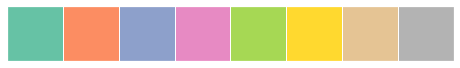

In [114]:
sns.set()
sns.set_palette("Set2")
sns.palplot(sns.color_palette())

<AxesSubplot:xlabel='algorithm', ylabel='timePerInf'>

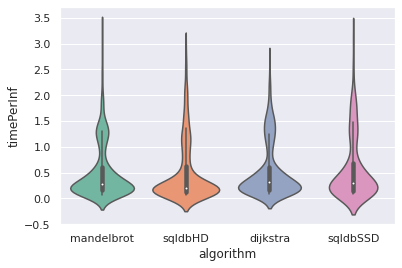

In [115]:
temp = df[["algorithm", "timePerInf"]]
sns.violinplot(data=temp, y="timePerInf", x="algorithm")

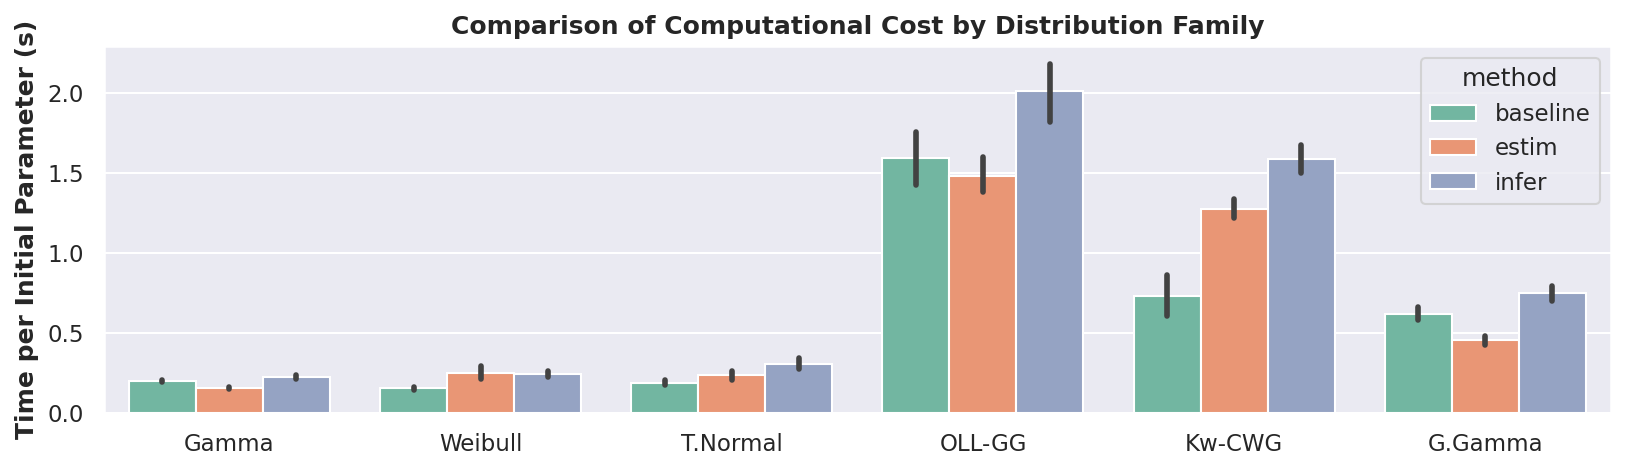

In [121]:
temp = df[["model", "timePerInf", "infMethod"]]
temp = temp[temp["infMethod"] != "c1"]
temp = temp[temp["infMethod"] != "c2"]
temp = temp[temp["infMethod"] != "c4"]
temp = temp[temp["infMethod"] != "iteratedC"]
#temp = temp[temp["infMethod"] != "standard"]
temp = temp[temp["model"] != "Normal"]
temp = temp[temp["model"] != "Lognormal"]
temp = temp[temp["model"] != "E.Weibull"]

temp["infMethod"] = temp["infMethod"].map({
        "c3": "estim",
        "inferC": "infer",
        "standard": "baseline"
    })

temp.columns = temp.columns.map({
        "model": "model",
        "timePerInf": "timePerInf",
        "infMethod": "method"
    })

plt.figure(figsize=(1.1*10, 1.1*3), dpi=150)
sns.barplot(data=temp, y="timePerInf", x="model", hue="method", hue_order=["baseline", "estim", "infer"])
#sns.boxplot(data=temp, y="timePerInf", x="model")
#plt.ylim([-0.1, 2.4])
#plt.xlabel("Model", fontdict={"weight": "bold"})
plt.xlabel("")
plt.ylabel("Time per Initial Parameter (s)", fontdict={"weight": "bold"})
plt.title("Comparison of Computational Cost by Distribution Family", fontdict={ "weight": "bold"})
plt.tight_layout()
plt.savefig("paper-img/time-by-distribution-family.pdf")

## Now we see the value of infTime.mean

In [86]:
temp = df[["model", "infTime.mean", "infMethod"]]
temp = temp[temp["infMethod"] != "c1"]
temp = temp[temp["infMethod"] != "c2"]
temp = temp[temp["infMethod"] != "c4"]
temp = temp[temp["infMethod"] != "iteratedC"]
temp = temp[temp["infMethod"] != "standard"]
temp = temp[temp["model"] != "Normal"]
temp = temp[temp["model"] != "Lognormal"]
temp = temp[temp["model"] != "E.Weibull"]

temp["infMethod"] = temp["infMethod"].map({
        "c3": "estim",
        "inferC": "infer"
    })

temp.columns = temp.columns.map({
        "model": "model",
        "infTime.mean": "infTime.mean",
        "infMethod": "method"
    })

plt.figure(figsize=(1.1*10, 1.1*3), dpi=150)
sns.barplot(data=temp, y="infTime.mean", x="model", hue="method", hue_order=sorted(temp.method.unique()))
#sns.boxplot(data=temp, y="timePerInf", x="model")
#plt.ylim([-0.1, 2.4])
#plt.xlabel("Model", fontdict={"weight": "bold"})
plt.xlabel("")
plt.ylabel("Time per Initial Parameter (s)", fontdict={"weight": "bold"})
plt.title("Comparison of Computational Cost by Distribution Family", fontdict={ "weight": "bold"})
plt.tight_layout()
plt.savefig("paper-img/time-by-distribution-family-onlybest.pdf")

TypeError: '<' not supported between instances of 'float' and 'str'

<Figure size 1650x495 with 0 Axes>

/home/mathjs/.local/lib/python3.6/site-packages/seaborn/palettes.py:1021: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette == "reset":


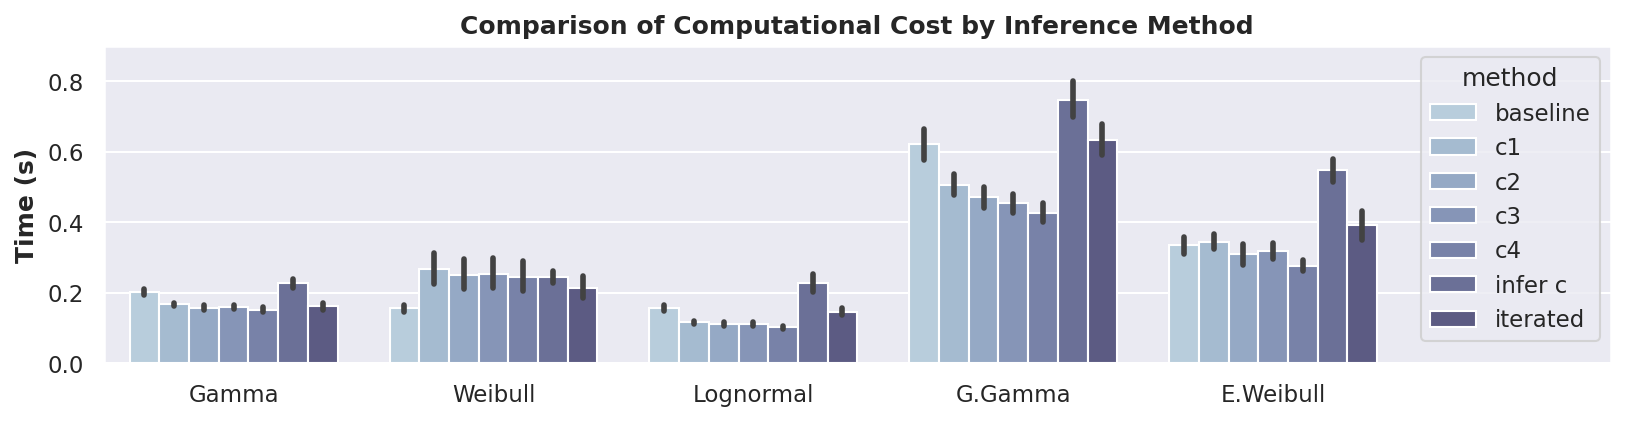

In [107]:
temp = df[["model", "timePerInf", "infMethod"]]
temp = temp[temp["model"] != "T.Normal"]
temp = temp[temp["model"] != "Normal"]
temp = temp[temp["model"] != "Kw-CWG"]
temp = temp[temp["model"] != "OLL-GG"]

temp["method"] = temp["infMethod"].map({
        "inferC": "infer c",
        "iteratedC": "iterated", 
        "standard": "baseline",
        "c1": "c1", "c2": "c2", "c3": "c3", "c4": "c4"
    })

obj = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.set(palette=obj(np.linspace(0.1, 0.7, num=7)))
plt.figure(figsize=(1.1*10, 1.1*2.7), dpi=150)
sns.barplot(data=temp, y="timePerInf", x="model", hue="method", hue_order=sorted(temp.method.unique()))
#sns.boxplot(data=temp, y="timePerInf", x="model")
plt.ylim([0, 0.9])
plt.xlim([-0.5, 5.3])
#plt.xlabel("Model", fontdict={"weight": "bold"})
plt.ylabel("Time (s)", fontdict={"weight": "bold"})
plt.xlabel("")
plt.title("Comparison of Computational Cost by Inference Method", fontdict={ "weight": "bold"})
plt.tight_layout()
plt.savefig("monograph-img/time-by-inference-method.pdf")

array([[0.92907237, 0.68878959, 0.50411509, 1.        ],
       [0.90732341, 0.4939774 , 0.38990532, 1.        ],
       [0.83765537, 0.30784814, 0.3723105 , 1.        ],
       [0.66635279, 0.22717328, 0.43008427, 1.        ],
       [0.47936222, 0.18006056, 0.43733022, 1.        ],
       [0.29408557, 0.13721193, 0.38442775, 1.        ]])

## Again, lets see infTime.mean

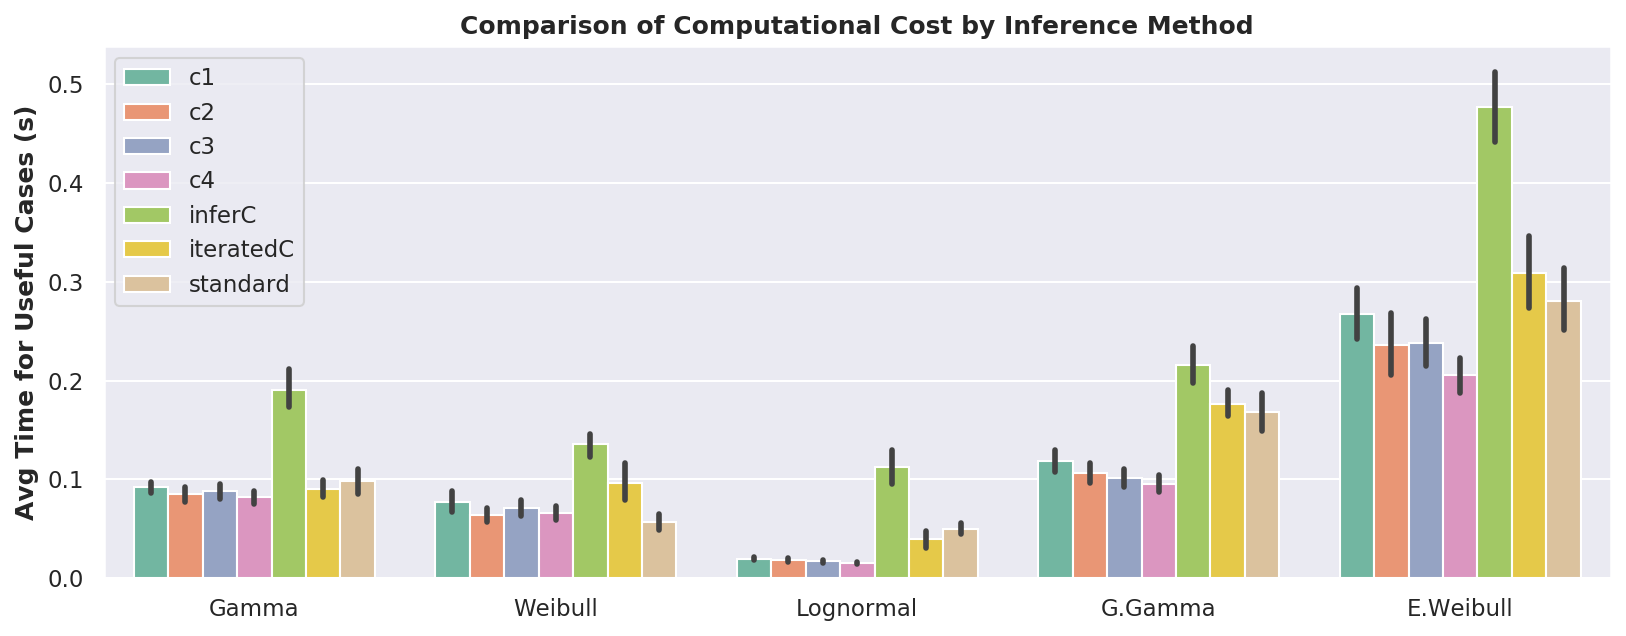

In [274]:
temp = df[["model", "infTime.mean", "infMethod"]]
temp = temp[temp["model"] != "T.Normal"]
temp = temp[temp["model"] != "Kw-CWG"]
temp = temp[temp["model"] != "OLL-GG"]
temp = temp[temp["model"] != "Normal"]

plt.figure(figsize=(1.1*10, 1.1*4), dpi=150)
sns.barplot(data=temp, y="infTime.mean", x="model", hue="infMethod", hue_order=sorted(temp.infMethod.unique()))
#sns.boxplot(data=temp, y="timePerInf", x="model")
#plt.ylim([-0.1, 2.4])
#plt.xlabel("Model", fontdict={"weight": "bold"})
plt.ylabel("Avg Time for Useful Cases (s)", fontdict={"weight": "bold"})
plt.xlabel("")
plt.title("Comparison of Computational Cost by Inference Method", fontdict={ "weight": "bold"})
plt.legend(loc="upper left", ncol=1)
plt.tight_layout()
plt.savefig("monograph-img/time-by-inference-method-onlybest.pdf")

# Error bars above are 95% confidence intervals obtained by bootstrapping.

Text(0.5, 0, '')

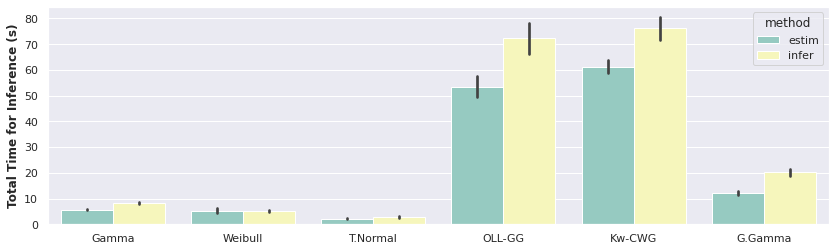

In [190]:
temp = df[["model", "elapsed.time", "infMethod"]]
temp = temp[temp["infMethod"] != "c1"]
temp = temp[temp["infMethod"] != "c2"]
temp = temp[temp["infMethod"] != "c4"]
temp = temp[temp["infMethod"] != "iteratedC"]
temp = temp[temp["infMethod"] != "standard"]
temp = temp[temp["model"] != "Normal"]
temp = temp[temp["model"] != "Lognormal"]
temp = temp[temp["model"] != "E.Weibull"]


temp["infMethod"] = temp["infMethod"].map({
        "c3": "estim",
        "inferC": "infer"
    })

temp.columns = temp.columns.map({
        "model": "model",
        "elapsed.time": "elapsed.time",
        "infMethod": "method"
    })

plt.figure(figsize=(14, 4))
sns.barplot(data=temp, y="elapsed.time", x="model", hue="method")
#sns.boxplot(data=temp, y="timePerInf", x="model")
#plt.ylim([-0.1, 2.4])
#plt.xlabel("Model", fontdict={"weight": "bold"})
plt.ylabel("Total Time for Inference (s)", fontdict={"weight": "bold"})
plt.xlabel("")

# Now to evaluate the subtracted -2l

In [65]:
bestLikelihoods = [] 

for exp in df["experiment"].unique():
    temp = df[df["experiment"] == exp]
    idx = np.argsort(temp["-2l"])[0]
    
    bestLikelihoods.append(temp.loc[idx,:])

bestLikelihoods = pd.DataFrame(bestLikelihoods)

In [68]:
alldfs = []

for exper in bestLikelihoods.title.unique():
    temp = bestLikelihoods[bestLikelihoods["title"] == exper]
    temp = temp.sort_values(by="infMethod")
    temp = temp[["model", "title", "-2l", "infMethod"]]
    alldfs.append(temp)

for l in alldfs:
    l["-2l"] = - (l["-2l"] - l["-2l"].max() - 200)

key = [ i["-2l"].max() for i in alldfs ]
idx = np.argsort(key)
    
aux = [ alldfs[i] for i in idx ]
alldfs = aux
alldfs

[       model               title         -2l  infMethod
 6     Kw-CWG  SqldbHD-Halley-100  202.150211         c1
 6     Kw-CWG  SqldbHD-Halley-100  202.322864         c2
 6     Kw-CWG  SqldbHD-Halley-100  200.000000         c3
 6     Kw-CWG  SqldbHD-Halley-100  200.384914         c4
 4  Lognormal  SqldbHD-Halley-100  203.281352     inferC
 4  Lognormal  SqldbHD-Halley-100  203.211334  iteratedC
 8  E.Weibull  SqldbHD-Halley-100  203.008976   standard,
        model                      title         -2l  infMethod
 8  E.Weibull  Mandelbrot-Andromeda-5000  202.861918         c1
 8  E.Weibull  Mandelbrot-Andromeda-5000  203.027109         c2
 5     OLL-GG  Mandelbrot-Andromeda-5000  201.877877         c3
 5     OLL-GG  Mandelbrot-Andromeda-5000  202.503070         c4
 4  Lognormal  Mandelbrot-Andromeda-5000  203.398195     inferC
 8  E.Weibull  Mandelbrot-Andromeda-5000  203.433176  iteratedC
 8  E.Weibull  Mandelbrot-Andromeda-5000  200.000000   standard,
        model               ti

37


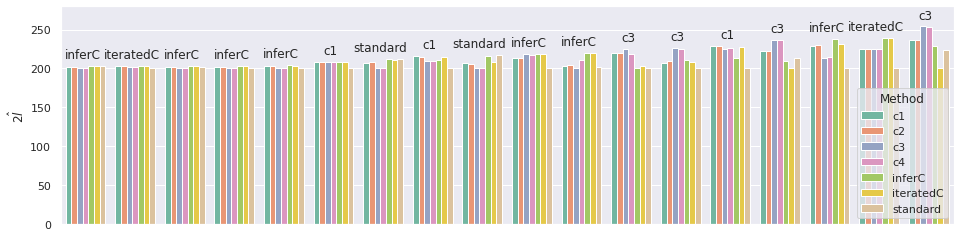

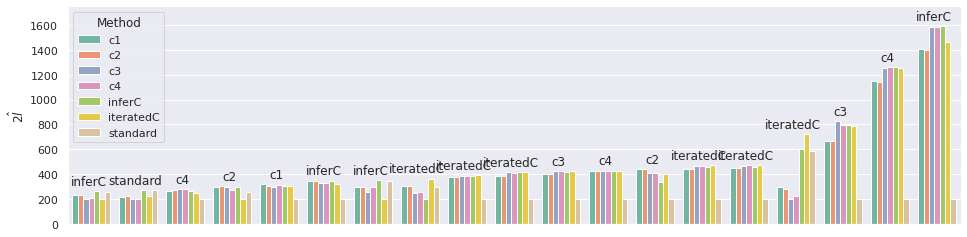

In [69]:
print(len(alldfs))

def annotate(ax, displ=+50):
    methods = ["c1", "c2", "c3", "c4", "inferC", "iteratedC", "standard"]
    
    patches = sorted(ax.patches, key=lambda x: x.get_x())
    while(len(patches) > 0):
        patchGroup = patches[0:7]
        patches = patches[7:]
        
        x = [p.get_x() for p in patchGroup ]
        y = [p.get_height() for p in patchGroup ]
        
        x = np.mean(x)
        idx = np.argsort(y)[-1]
        y = np.max(y)
        
        ax.text(x, y + displ, methods[idx], horizontalalignment="center")

plt.figure(figsize=[16, 4])
temp = pd.concat(alldfs[0:18])
ax = sns.barplot(data=temp, x="title", y="-2l", hue="infMethod")
annotate(ax, 10)
plt.ylim([0, 280])
plt.ylabel("$2 \hat{l}$", fontdict={ "weight": "bold" })
plt.xlabel("")
ax.set_xticklabels([ "" for i in ax.get_xticklabels() ])
#plt.legend(["c1 (4)", "c2 (2)", "c3 (6)", "c4 (3)", "inferC (11)", "iteratedC (8)", "standard (3)"], loc="lower right")
plt.legend(loc="lower right", title="Method")
plt.show()

plt.figure(figsize=[16, 4])
temp = pd.concat(alldfs[18:])
ax = sns.barplot(data=temp, x="title", y="-2l", hue="infMethod")
annotate(ax)
#labs = list(ax.get_yticks())
#labs = [ str(int(i) + 4000) for i in labs ]
plt.ylim([0, 1750])
plt.ylabel("$2 \hat{l}$", fontdict={ "weight": "bold" })
plt.xlabel("")
plt.legend(title="Method")
#ax.set_yticklabels(labs)
ax.set_xticklabels([ "" for i in ax.get_xticklabels() ])
plt.show()

In [70]:
alldfs = []

for exper in bestLikelihoods.title.unique():
    temp = bestLikelihoods[bestLikelihoods["title"] == exper]
    temp = temp.sort_values(by="infMethod")
    temp = temp[["model", "title", "crossValid", "infMethod"]]
    temp = temp[temp["infMethod"] != "iteratedC"]
    alldfs.append(temp)

for l in alldfs:
    l["crossValid"] = - (l["crossValid"] - l["crossValid"].max() - 20)

key = [ i["crossValid"].max() for i in alldfs ]
idx = np.argsort(key)
    
aux = [ alldfs[i] for i in idx ]
alldfs = aux
alldfs

[       model                      title  crossValid infMethod
 8  E.Weibull  Mandelbrot-Andromeda-5000   20.928854        c1
 8  E.Weibull  Mandelbrot-Andromeda-5000   20.695518        c2
 5     OLL-GG  Mandelbrot-Andromeda-5000   20.835959        c3
 5     OLL-GG  Mandelbrot-Andromeda-5000   20.506113        c4
 4  Lognormal  Mandelbrot-Andromeda-5000   20.572427    inferC
 8  E.Weibull  Mandelbrot-Andromeda-5000   20.000000  standard,
        model               title  crossValid infMethod
 6     Kw-CWG  SqldbHD-Halley-100   20.000000        c1
 6     Kw-CWG  SqldbHD-Halley-100   20.556095        c2
 6     Kw-CWG  SqldbHD-Halley-100   20.106534        c3
 6     Kw-CWG  SqldbHD-Halley-100   20.809762        c4
 4  Lognormal  SqldbHD-Halley-100   20.542139    inferC
 8  E.Weibull  SqldbHD-Halley-100   21.287050  standard,
        model               title  crossValid infMethod
 6     Kw-CWG  SqldbHD-Halley-300   20.292541        c1
 6     Kw-CWG  SqldbHD-Halley-300   20.720056        

37


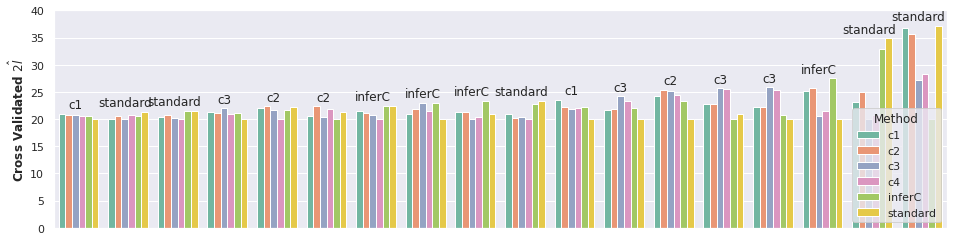

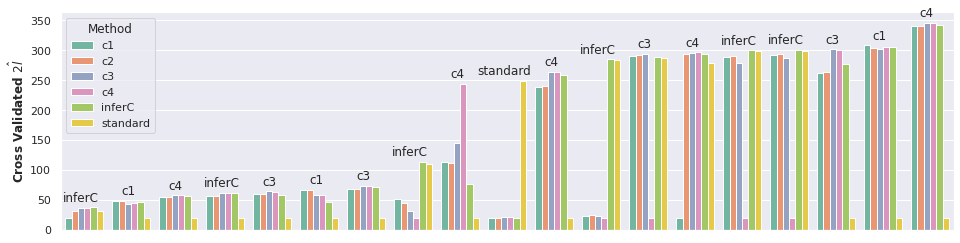

In [71]:
print(len(alldfs))

def annotate(ax, displ=+50):
    methods = ["c1", "c2", "c3", "c4", "inferC", "standard"]
    
    patches = sorted(ax.patches, key=lambda x: x.get_x())
    while(len(patches) > 0):
        patchGroup = patches[0:6]
        patches = patches[6:]
        
        x = [p.get_x() for p in patchGroup ]
        y = [p.get_height() for p in patchGroup ]
        
        x = np.mean(x)
        idx = np.argsort(y)[-1]
        y = np.max(y)
        
        ax.text(x, y + displ, methods[idx], horizontalalignment="center")

plt.figure(figsize=[16, 4])
temp = pd.concat(alldfs[0:18])
ax = sns.barplot(data=temp, x="title", y="crossValid", hue="infMethod")
annotate(ax, 1)
plt.ylim([0, 40])
plt.ylabel("Cross Validated $2 \hat{l}$", fontdict={ "weight": "bold" })
plt.xlabel("")
ax.set_xticklabels([ "" for i in ax.get_xticklabels() ])
#plt.legend(["c1 (4)", "c2 (2)", "c3 (6)", "c4 (3)", "inferC (11)", "iteratedC (8)", "standard (3)"], loc="lower right")
plt.legend(loc="lower right", title="Method")
plt.show()

plt.figure(figsize=[16, 4])
temp = pd.concat(alldfs[18:])
ax = sns.barplot(data=temp, x="title", y="crossValid", hue="infMethod")
annotate(ax, 10)
#labs = list(ax.get_yticks())
#labs = [ str(int(i) + 4000) for i in labs ]
#plt.ylim([-11000, 0])
plt.ylabel("Cross Validated $2 \hat{l}$", fontdict={ "weight": "bold" })
plt.xlabel("")
plt.legend(title="Method")
#ax.set_yticklabels(labs)
ax.set_xticklabels([ "" for i in ax.get_xticklabels() ])
plt.show()

In [72]:
alldfs = []

for exper in bestLikelihoods.title.unique():
    temp = bestLikelihoods[bestLikelihoods["title"] == exper]
    temp = temp.sort_values(by="infMethod")
    temp = temp[["model", "title", "-2l", "infMethod"]]
    alldfs.append(temp)

for l in alldfs:
    l["-2l"] = - (l["-2l"] - l["-2l"].min())

key = [ i["-2l"].max() for i in alldfs ]
idx = np.argsort(key)
    
aux = [ alldfs[i] for i in idx ]
alldfs = aux
alldfs

[       model               title         -2l  infMethod
 4  Lognormal  Dijkstra-Lasdpc-1M  -11.404576         c1
 4  Lognormal  Dijkstra-Lasdpc-1M  -11.571735         c2
 8  E.Weibull  Dijkstra-Lasdpc-1M   -3.671347         c3
 8  E.Weibull  Dijkstra-Lasdpc-1M   -3.152038         c4
 4  Lognormal  Dijkstra-Lasdpc-1M   -9.500380     inferC
 6     Kw-CWG  Dijkstra-Lasdpc-1M   -0.000000  iteratedC
 8  E.Weibull  Dijkstra-Lasdpc-1M -190.751192   standard,
        model                 title         -2l  infMethod
 4  Lognormal  Dijkstra-Lasdpc-500K  -26.807506         c1
 4  Lognormal  Dijkstra-Lasdpc-500K  -27.882436         c2
 8  E.Weibull  Dijkstra-Lasdpc-500K   -4.622467         c3
 8  E.Weibull  Dijkstra-Lasdpc-500K   -4.013745         c4
 5     OLL-GG  Dijkstra-Lasdpc-500K  -16.351941     inferC
 4  Lognormal  Dijkstra-Lasdpc-500K   -0.000000  iteratedC
 6     Kw-CWG  Dijkstra-Lasdpc-500K -273.773162   standard,
        model                    title        -2l  infMethod
 5     OL

37


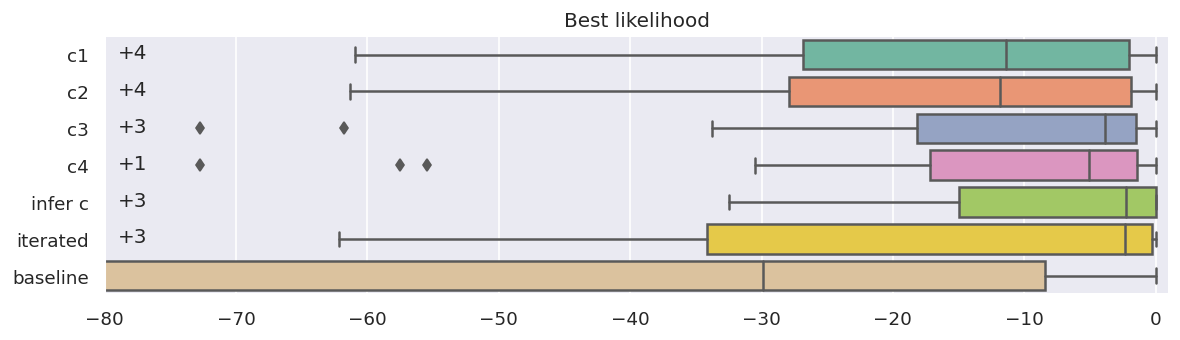

In [73]:
print(len(alldfs))
  
plt.figure(figsize=[1.0*10, 1.0*3], dpi=120)
temp = pd.concat(alldfs)

temp["method"] = temp["infMethod"].map({
        "inferC": "infer c",
        "iteratedC": "iterated", 
        "standard": "baseline",
        "c1": "c1", "c2": "c2", "c3": "c3", "c4": "c4"
    })

sns.set(palette="Set2")
sns.boxplot(x="-2l", y="method", data=temp)
#plt.title("Comparison of Model Quality by Inference Method", fontdict={ "weight": "bold" })
#plt.xlabel("$2 \hat{l}$ Distance to Best Performing Inference Method", fontdict={ "weight": "bold" })
#plt.ylabel("Inference Method", fontdict={ "weight": "bold" })
plt.xlabel("")
plt.ylabel("")
plt.title("Best likelihood")
plt.xlim([-80, 1])
#plt.xlim([-600, 0])
plt.text(-79, 0 + 0.1, "+4")
plt.text(-79, 1 + 0.1, "+4")
plt.text(-79, 2 + 0.1, "+3")
plt.text(-79, 3 + 0.1, "+1")
plt.text(-79, 4 + 0.1, "+3")
plt.text(-79, 5 + 0.1, "+3")
#plt.text(-78, 6 + 0.2, "+3")
plt.tight_layout()
plt.savefig("paper-img/inference-method-best-2l.pdf")

In [76]:
alldfs = []

for exper in bestLikelihoods.title.unique():
    temp = bestLikelihoods[bestLikelihoods["title"] == exper]
    temp = temp.sort_values(by="infMethod")
    temp = temp[["model", "title", "crossValid", "infMethod"]]
    temp = temp[temp["infMethod"] != "iteratedC"]
    alldfs.append(temp)

for l in alldfs:
    l["crossValid"] = - (l["crossValid"] - l["crossValid"].min())

key = [ i["crossValid"].max() for i in alldfs ]
idx = np.argsort(key)
    
aux = [ alldfs[i] for i in idx ]
alldfs = aux
alldfs

[       model               title  crossValid infMethod
 4  Lognormal  Dijkstra-Lasdpc-1M   -1.968482        c1
 4  Lognormal  Dijkstra-Lasdpc-1M   -2.855612        c2
 8  E.Weibull  Dijkstra-Lasdpc-1M   -0.182979        c3
 8  E.Weibull  Dijkstra-Lasdpc-1M   -0.000000        c4
 4  Lognormal  Dijkstra-Lasdpc-1M   -1.112250    inferC
 8  E.Weibull  Dijkstra-Lasdpc-1M  -37.598020  standard,
        model                 title  crossValid infMethod
 4  Lognormal  Dijkstra-Lasdpc-500K   -5.558041        c1
 4  Lognormal  Dijkstra-Lasdpc-500K   -5.355122        c2
 8  E.Weibull  Dijkstra-Lasdpc-500K   -0.230725        c3
 8  E.Weibull  Dijkstra-Lasdpc-500K   -0.000000        c4
 5     OLL-GG  Dijkstra-Lasdpc-500K   -3.171264    inferC
 6     Kw-CWG  Dijkstra-Lasdpc-500K -325.951724  standard,
        model                    title  crossValid infMethod
 5     OLL-GG  Mandelbrot-Lasdpc-30000   -2.592708        c1
 5     OLL-GG  Mandelbrot-Lasdpc-30000   -2.339701        c2
 3   T.Normal  Ma

In [77]:
sns.set()
sns.set_palette("Set2")
pal = sns.color_palette()
pal = pal[:5] + pal[6:]
sns.set_palette(pal)

37
        model                    title  crossValid infMethod
8   E.Weibull       Dijkstra-Lasdpc-1M   -0.182979     estim
4   Lognormal       Dijkstra-Lasdpc-1M   -1.112250     infer
8   E.Weibull     Dijkstra-Lasdpc-500K   -0.230725     estim
5      OLL-GG     Dijkstra-Lasdpc-500K   -3.171264     infer
3    T.Normal  Mandelbrot-Lasdpc-30000   -0.000000     estim
..        ...                      ...         ...       ...
5      OLL-GG   SqldbHD-Andromeda-1500   -1.816797     infer
3    T.Normal  Mandelbrot-Lasdpc-10000   -0.000000     estim
6      Kw-CWG  Mandelbrot-Lasdpc-10000   -5.076352     infer
6      Kw-CWG       SqldbHD-Lasdpc-150   -1.692250     estim
5      OLL-GG       SqldbHD-Lasdpc-150   -0.000000     infer

[74 rows x 4 columns]


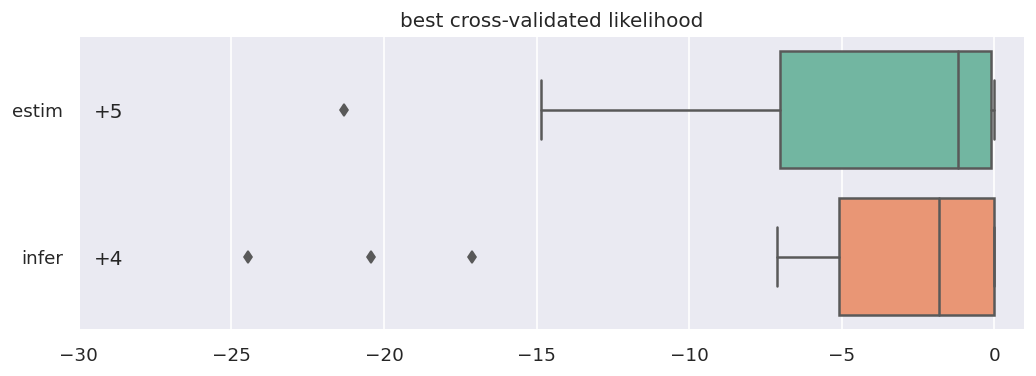

In [86]:
print(len(alldfs))

plt.figure(figsize=[1.1*8, 1.1*3], dpi=120)
temp = pd.concat(alldfs)

temp = temp[temp["infMethod"] != "c1"]
temp = temp[temp["infMethod"] != "c2"]
temp = temp[temp["infMethod"] != "c4"]
temp = temp[temp["infMethod"] != "iteratedC"]
temp = temp[temp["infMethod"] != "standard"]

temp["infMethod"] = temp["infMethod"].map({
        "c3": "estim",
        "inferC": "infer"
    })

print(temp)

sns.boxplot(y="infMethod", x="crossValid", data=temp)
#plt.title("Comparison of Model Quality by Inference Method", fontdict={ "weight": "bold" })
#plt.xlabel("Cross Validated $2 \hat{l}$ Distance to Best Inference Method", fontdict={ "weight": "bold" })
#plt.ylabel("Inference Method", fontdict={ "weight": "bold" })
plt.xlabel("")
plt.ylabel("")
plt.title("best cross-validated likelihood")
plt.xlim([-30, 1])
plt.text(-29.5, 0 + 0.05, "+5")
plt.text(-29.5, 1 + 0.05, "+4")
#plt.text(-29.5, 2 + 0.1, "+4")
#plt.text(-29.5, 3 + 0.1, "+5")
#plt.text(-29.5, 4 + 0.1, "+1")
#plt.text(-39, 5 + 0.2, "+5")
plt.tight_layout()
plt.savefig("paper-img/inference-method-best-cross-valid.pdf")
sns.set()
sns.set_palette("Set2")

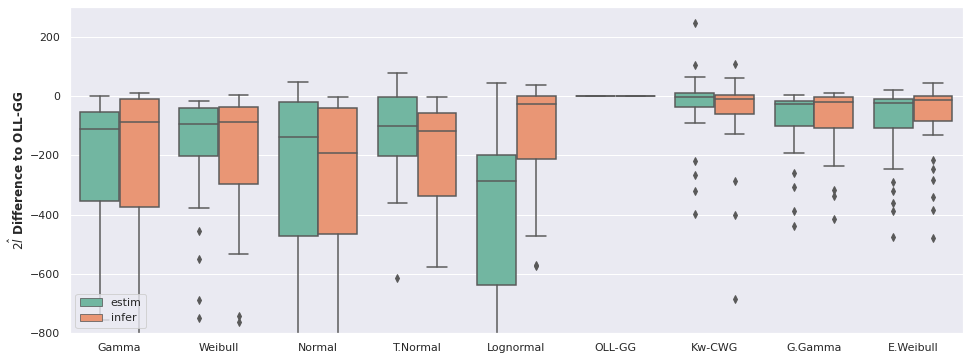

In [87]:
filtered = df[df["infMethod"] != "standard"]

alldfs = []

for exper in filtered.title.unique():
    temp = filtered[filtered["title"] == exper]

    for meth in temp.infMethod.unique():
        temp2 = temp[temp["infMethod"] == meth]
        temp2 = temp2.sort_values(by="infMethod")
        temp2 = temp2[["model", "title", "-2l", "infMethod"]]
        alldfs.append(temp2)

for l in alldfs:
    l["-2l"] = -l["-2l"]
    l["-2l"] = l["-2l"] - float(l[l["model"] == "OLL-GG"]["-2l"])

#key = [ i["-2l"].max() for i in alldfs ]
#idx = np.argsort(key)

#aux = [ alldfs[i] for i in idx ]
#alldfs = aux

temp = pd.concat(alldfs)

temp = temp[temp["infMethod"] != "c1"]
temp = temp[temp["infMethod"] != "c2"]
temp = temp[temp["infMethod"] != "c4"]
temp = temp[temp["infMethod"] != "iteratedC"]
temp = temp[temp["infMethod"] != "standard"]

temp["infMethod"] = temp["infMethod"].map({
        "c3": "estim",
        "inferC": "infer"
    })

plt.figure(figsize=[16, 6])
sns.boxplot(x="model", y="-2l", data=temp, hue="infMethod", hue_order=sorted(temp.infMethod.unique()))
plt.ylabel("$2 \hat{l}$ Difference to OLL-GG", fontdict={ "weight": "bold" })
plt.xlabel("", fontdict={ "weight": "bold" })
plt.ylim([-800, 300])
plt.legend(loc="lower left")

# In general, c1 = c2 and c3 = c4 in terms of similar behavior, so we can omit them

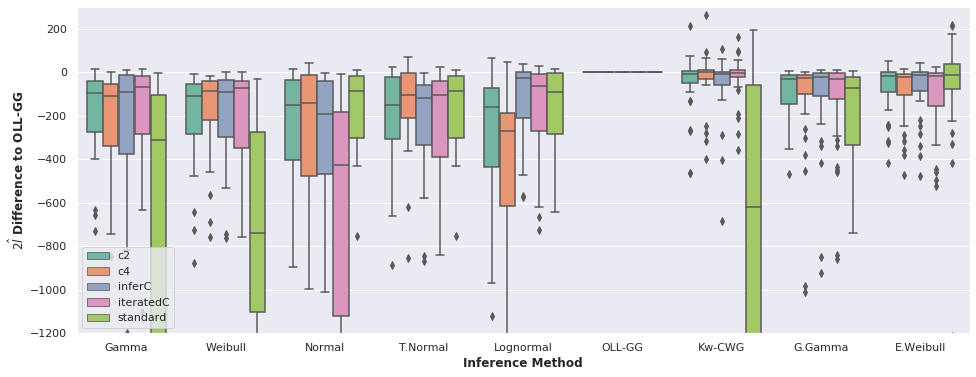

In [182]:
#filtered = df[df["infMethod"] != "standard"]
filtered = df[df["infMethod"] != "c1"]
filtered = filtered[filtered["infMethod"] != "c3"]

alldfs = []

for exper in filtered.title.unique():
    temp = filtered[filtered["title"] == exper]

    for meth in temp.infMethod.unique():
        temp2 = temp[temp["infMethod"] == meth]
        temp2 = temp2.sort_values(by="infMethod")
        temp2 = temp2[["model", "title", "-2l", "infMethod"]]
        alldfs.append(temp2)

for l in alldfs:
    l["-2l"] = -l["-2l"]
    l["-2l"] = l["-2l"] - float(l[l["model"] == "OLL-GG"]["-2l"])

#key = [ i["-2l"].max() for i in alldfs ]
#idx = np.argsort(key)

#aux = [ alldfs[i] for i in idx ]
#alldfs = aux

temp = pd.concat(alldfs)


plt.figure(figsize=[16, 6])
sns.boxplot(x="model", y="-2l", data=temp, hue="infMethod", hue_order=sorted(temp.infMethod.unique()))
plt.ylabel("$2 \hat{l}$ Difference to OLL-GG", fontdict={ "weight": "bold" })
plt.xlabel("Inference Method", fontdict={ "weight": "bold" })
plt.ylim([-1200, 300])
plt.legend(loc="lower left")

# We can say the same about inferC = iteratedC and c2 = c4

# They aren't much similar, but for what we are trying to show here, they are sufficiently similar

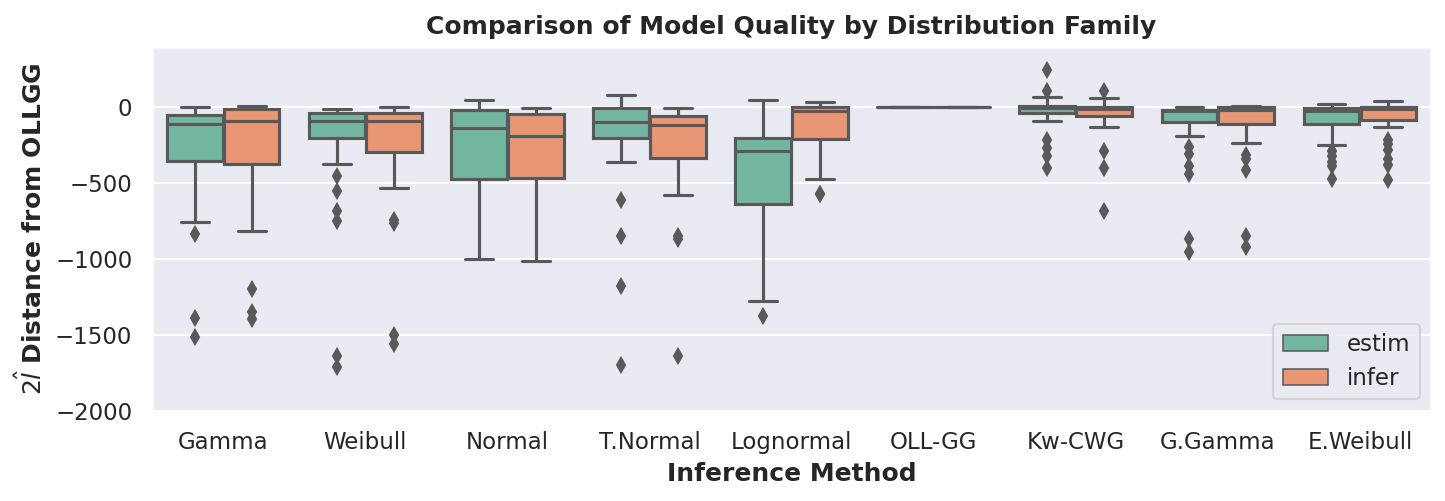

In [91]:
#filtered = df[df["infMethod"] != "standard"]
filtered = df[df["infMethod"] != "c1"]
filtered = filtered[filtered["infMethod"] != "c2"]
filtered = filtered[filtered["infMethod"] != "iteratedC"]
filtered = filtered[filtered["infMethod"] != "c4"]

alldfs = []

for exper in filtered.title.unique():
    temp = filtered[filtered["title"] == exper]

    for meth in temp.infMethod.unique():
        temp2 = temp[temp["infMethod"] == meth]
        temp2 = temp2.sort_values(by="infMethod")
        temp2 = temp2[["model", "title", "-2l", "infMethod"]]
        alldfs.append(temp2)

for l in alldfs:
    l["-2l"] = -l["-2l"]
    l["-2l"] = l["-2l"] - float(l[l["model"] == "OLL-GG"]["-2l"])

#key = [ i["-2l"].max() for i in alldfs ]
#idx = np.argsort(key)

#aux = [ alldfs[i] for i in idx ]
#alldfs = aux

temp = pd.concat(alldfs)

temp = temp[temp["infMethod"] != "c1"]
temp = temp[temp["infMethod"] != "c2"]
temp = temp[temp["infMethod"] != "c4"]
temp = temp[temp["infMethod"] != "iteratedC"]
temp = temp[temp["infMethod"] != "standard"]

temp["infMethod"] = temp["infMethod"].map({
        "c3": "estim",
        "inferC": "infer"
    })

plt.figure(figsize=[0.7*14, 0.7*5], dpi=150)
sns.boxplot(x="model", y="-2l", data=temp, hue="infMethod", hue_order=sorted(temp.infMethod.unique()))
plt.title("Comparison of Model Quality by Distribution Family", fontdict={ "weight": "bold" })
plt.ylabel("$2 \hat{l}$ Distance from OLLGG", fontdict={ "weight": "bold" })
plt.xlabel("Inference Method", fontdict={ "weight": "bold" })
plt.ylim([-2000, 400])
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("paper-img/2l-by-distribution-family.pdf")

### Above, all outliers of Kw-CWG, GGamma and EWeibull are all shown in the graph.

### Below too

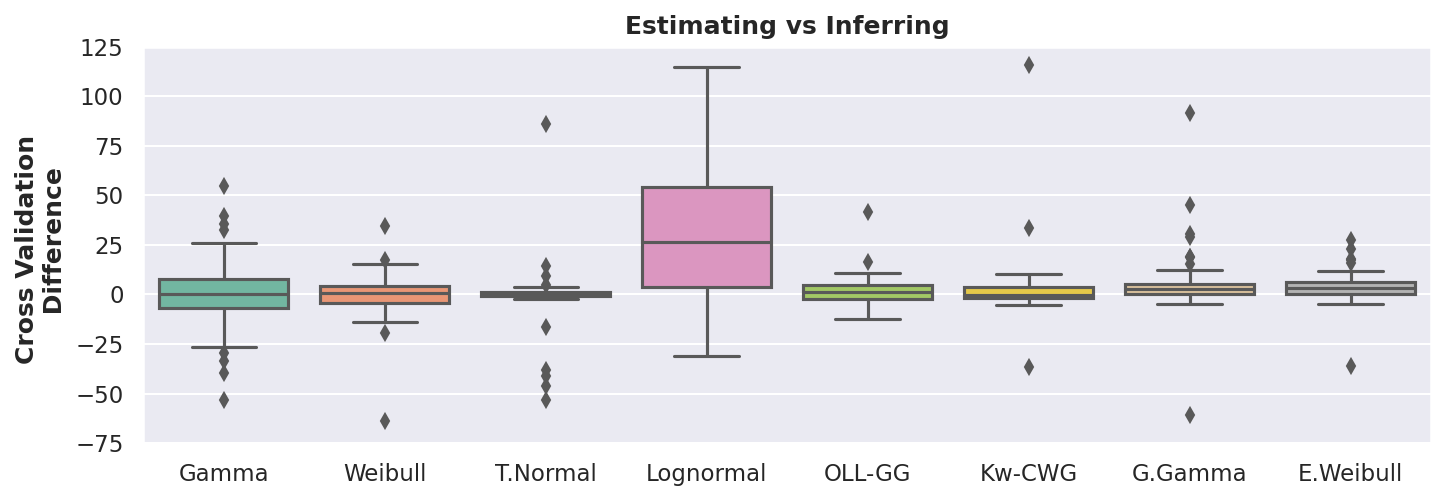

In [159]:
#filtered = df[df["infMethod"] != "standard"]
filtered = df[df["infMethod"] != "c1"]
filtered = filtered[filtered["infMethod"] != "c2"]
filtered = filtered[filtered["infMethod"] != "iteratedC"]
filtered = filtered[filtered["infMethod"] != "c4"]
filtered = filtered[filtered["infMethod"] != "standard"]
filtered = filtered[filtered["model"] != "Normal"]


alldfs = []

for exper in filtered.title.unique():
    temp = filtered[filtered["title"] == exper]
#    temp = temp[["model", "title", "crossValid", "infMethod"]]
#    alldfs.append(temp)
    
    for mod in temp.model.unique():
        temp2 = temp[temp["model"] == mod]
        temp2 = temp2.sort_values(by="infMethod")
        temp2 = temp2[["model", "title", "crossValid", "infMethod"]]
        diff = float(temp2[temp2.infMethod == "c3"]["crossValid"]) - float(temp2[temp2.infMethod == "inferC"]["crossValid"])
        diff = diff / 2
        alldfs.append([mod, diff])
        #print(temp2)
        
#for l in alldfs:
#    print(l)
#    l["crossValid"] = -l["crossValid"]
#    l["crossValid"] = l["crossValid"] - float(l[l["model"] == "OLL-GG"]["crossValid"])

#key = [ i["-2l"].max() for i in alldfs ]
#idx = np.argsort(key)

#aux = [ alldfs[i] for i in idx ]
#alldfs = aux

temp = pd.DataFrame(alldfs, columns=["model", "crossValid"])

plt.figure(figsize=[0.7*14, 0.7*5], dpi=150)
sns.boxplot(x="model", y="crossValid", data=temp)
plt.title("Estimating vs Inferring", fontdict={ "weight": "bold" })
plt.ylabel("Cross Validation \n Difference", fontdict={ "weight": "bold" })
plt.xlabel("")
plt.ylim([-75, 125])
#plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("paper-img/cross-valid-2l-by-distribution-family.pdf")

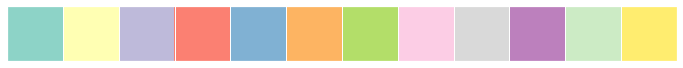

In [134]:
sns.set()
sns.set_palette("Set3")
sns.palplot(sns.color_palette())

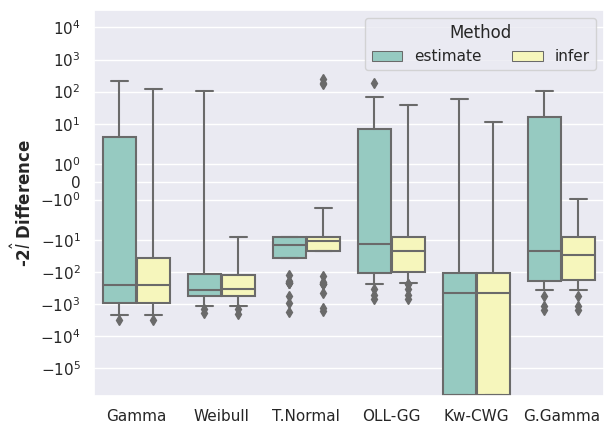

In [149]:
#filtered = df[df["infMethod"] != "standard"]
filtered = df[df["infMethod"] != "c1"]
filtered = filtered[filtered["infMethod"] != "c2"]
filtered = filtered[filtered["infMethod"] != "iteratedC"]
filtered = filtered[filtered["infMethod"] != "c4"]
filtered = filtered[filtered["model"] != "Normal"]
filtered = filtered[filtered["model"] != "Lognormal"]
filtered = filtered[filtered["model"] != "E.Weibull"]

key = "-2l"

alldfs = []

for exper in filtered.title.unique():
    temp = filtered[filtered["title"] == exper]
#    temp = temp[["model", "title", "crossValid", "infMethod"]]
#    alldfs.append(temp)
    
    for mod in temp.model.unique():
        temp2 = temp[temp["model"] == mod]
        temp2 = temp2.sort_values(by="infMethod")
        temp2 = temp2[["model", "title", key, "infMethod"]]
        
        diffEstim = float(temp2[temp2.infMethod == "c3"][key]) - float(temp2[temp2.infMethod == "standard"][key])
        diffEstim = diffEstim / 2
        
        diffInf = float(temp2[temp2.infMethod == "inferC"][key]) - float(temp2[temp2.infMethod == "standard"][key])
        diffInf = diffInf / 2
        
        alldfs.append([mod, diffEstim, "estimate"])
        alldfs.append([mod, diffInf, "infer"])
        
        #print(temp2)
        
#for l in alldfs:
#    print(l)
#    l["crossValid"] = -l["crossValid"]
#    l["crossValid"] = l["crossValid"] - float(l[l["model"] == "OLL-GG"]["crossValid"])

#key = [ i["-2l"].max() for i in alldfs ]
#idx = np.argsort(key)

#aux = [ alldfs[i] for i in idx ]
#alldfs = aux

temp = pd.DataFrame(alldfs, columns=["model", key, "method"])
#temp.loc[temp["model"] == "Kw-CWG",key] = temp[temp["model"] == "Kw-CWG"][key] / 1000
temp[key] = temp[key] - 8

plt.figure(figsize=[0.9*7, 0.9*5], dpi=100)
ax = plt.gca()
sns.boxplot(x="model", y=key, data=temp, hue="method")
plt.title("", fontdict={ "weight": "bold" })
plt.ylabel("-2$\hat{l}$ Difference", fontdict={ "weight": "bold" })
plt.xlabel("", fontdict={ "weight": "bold" })
#plt.ylim([-1e7, 1e6])
#plt.xlim([-0.5, 5.5])
plt.yscale("symlog")
#plt.yticks([-1e7, -1e5, -1e3, -1e1, 0, 1e1, 1e3, 1e5])
#ax.set_yticklabels( [ "$-10^{}$".format(i) for i in (7, 5, 3) ] + ["-1", "0", "1"] + [ "$10^{}$".format(i) for i in (1, 3, 5) ])
plt.legend(ncol=2, title="Method")
plt.tight_layout()
plt.savefig("paper-img/2l-comparison-inf-and-estim.pdf")

In [70]:
temp[temp["model"] == "Kw-CWG"]

,model,-2l,method
8,Kw-CWG,-695123.972409,estimate
9,Kw-CWG,-695132.401086,infer
20,Kw-CWG,-145.218526,estimate
21,Kw-CWG,-153.958841,infer
32,Kw-CWG,-111.751704,estimate
...,...,...,...
417,Kw-CWG,-691518.130675,infer
428,Kw-CWG,-689030.742901,estimate
429,Kw-CWG,-689026.180970,infer
440,Kw-CWG,-690556.343855,estimate


## Cant forget to use one information criteria too mate

## Nvm

FileNotFoundError: [Errno 2] No such file or directory: 'paper-img/AIC-2l-by-distribution-family.pdf'

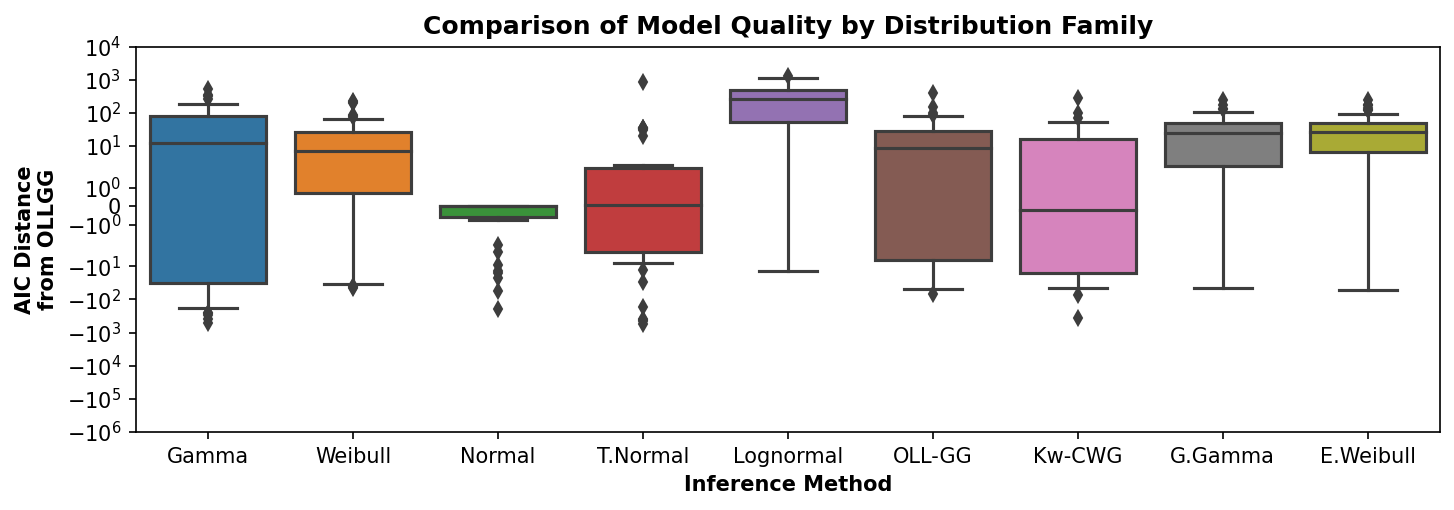

In [22]:
#filtered = df[df["infMethod"] != "standard"]
filtered = df[df["infMethod"] != "c1"]
filtered = filtered[filtered["infMethod"] != "c2"]
filtered = filtered[filtered["infMethod"] != "iteratedC"]
filtered = filtered[filtered["infMethod"] != "c4"]
filtered = filtered[filtered["infMethod"] != "standard"]

key = "-2l"

alldfs = []

for exper in filtered.title.unique():
    temp = filtered[filtered["title"] == exper]
#    temp = temp[["model", "title", "crossValid", "infMethod"]]
#    alldfs.append(temp)
    
    for mod in temp.model.unique():
        temp2 = temp[temp["model"] == mod]
        temp2 = temp2.sort_values(by="infMethod")
        temp2 = temp2[["model", "title", key, "infMethod"]]
        alldfs.append([mod, float(temp2[temp2.infMethod == "c3"][key]) - float(temp2[temp2.infMethod == "inferC"][key]) ])
        #print(temp2)
        
#for l in alldfs:
#    print(l)
#    l["crossValid"] = -l["crossValid"]
#    l["crossValid"] = l["crossValid"] - float(l[l["model"] == "OLL-GG"]["crossValid"])

#key = [ i["-2l"].max() for i in alldfs ]
#idx = np.argsort(key)

#aux = [ alldfs[i] for i in idx ]
#alldfs = aux

temp = pd.DataFrame(alldfs, columns=["model", key])

plt.figure(figsize=[0.7*14, 0.7*5], dpi=150)
sns.boxplot(x="model", y=key, data=temp)
plt.title("Comparison of Model Quality by Distribution Family", fontdict={ "weight": "bold" })
plt.ylabel("AIC Distance\nfrom OLLGG", fontdict={ "weight": "bold" })
plt.xlabel("Inference Method", fontdict={ "weight": "bold" })
plt.ylim([-1000000, 10000])
plt.yscale("symlog")
#plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("paper-img/AIC-2l-by-distribution-family.pdf")

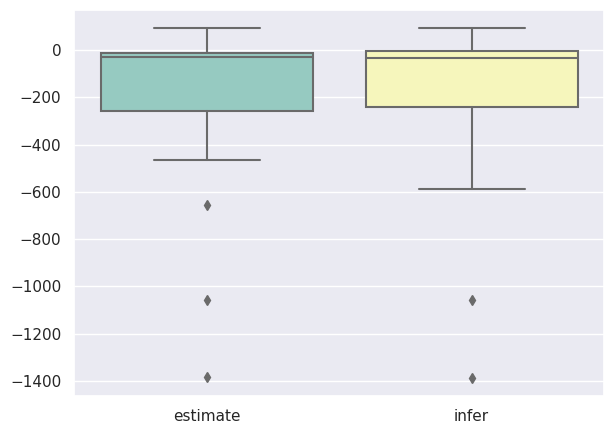

In [166]:
#filtered = df[df["infMethod"] != "standard"]
filtered = df[df["infMethod"] != "c1"]
filtered = filtered[filtered["infMethod"] != "c2"]
filtered = filtered[filtered["infMethod"] != "iteratedC"]
filtered = filtered[filtered["infMethod"] != "c4"]
filtered = filtered[filtered["model"] != "Normal"]
filtered = filtered[filtered["model"] != "Lognormal"]
filtered = filtered[filtered["model"] != "E.Weibull"]

key = "-2l"

alldfs = []

for exper in filtered.title.unique():
    temp = filtered[filtered["title"] == exper]
#    temp = temp[["model", "title", "crossValid", "infMethod"]]
#    alldfs.append(temp)
    
    standardLik = temp[temp["infMethod"] == "standard"][key]
    standardLik = np.min(standardLik[np.isfinite(standardLik)])
    c3Lik = np.min(temp[temp["infMethod"] == "c3"][key])
    infLik = np.min(temp[temp["infMethod"] == "inferC"][key])
    
    alldfs.append([ c3Lik - standardLik, infLik - standardLik ])
        
#for l in alldfs:
#    print(l)
#    l["crossValid"] = -l["crossValid"]
#    l["crossValid"] = l["crossValid"] - float(l[l["model"] == "OLL-GG"]["crossValid"])

#key = [ i["-2l"].max() for i in alldfs ]
#idx = np.argsort(key)

#aux = [ alldfs[i] for i in idx ]
#alldfs = aux

temp = pd.DataFrame(alldfs, columns=["estimate", "infer"])
temp = temp.melt()

temp = temp.drop(index=temp[temp["value"] > 250].index)

plt.figure(figsize=[0.9*7, 0.9*5], dpi=100)
sns.boxplot(x="variable", y="value", data=temp)
#plt.title("Comparison of Model Quality by Distribution Family", fontdict={ "weight": "bold" })
plt.ylabel("", fontdict={ "weight": "bold" })
plt.xlabel("")
#plt.ylabel("AIC Distance\nfrom OLLGG", fontdict={ "weight": "bold" })
#plt.xlabel("Inference Method", fontdict={ "weight": "bold" })
#plt.ylim([-1000000, 10000])
#plt.yscale("symlog")
#plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("paper-img/2l-comparison-estim-as-initial.pdf")